In [107]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skewnorm, norm

from src.utils import skew_to_alpha, moments
from src.sharpe_ratio_stats import estimated_sharpe_ratio, ann_estimated_sharpe_ratio, estimated_sharpe_ratio_stdev, probabilistic_sharpe_ratio

In [110]:
np.random.seed(0)

## Strategy 1 - *Simulate a distribution of returns with negative skewness*

In [111]:
MEAN_RETURNS = 0.01
STD_RETURNS  = 0.01
SKEW_RETURNS = -0.99  # must be between [-0.99, 0.99]

alpha = skew_to_alpha(SKEW_RETURNS)

dist_st1 = skewnorm(loc=MEAN_RETURNS, scale=STD_RETURNS, a=alpha)

In [112]:
# NOTE: scipy.skewnorm can not mantain the mean and std of the distribution while changing the skewness
true_mean_st1 = dist_st1.stats('m').item()
true_std_st1  = np.sqrt(dist_st1.stats('v').item())
true_skew_st1  = dist_st1.stats('s').item()
true_kurt_st1  = dist_st1.stats('k').item()+3
print('Long term true weekly mean returns st1: {:.2%}'.format(true_mean_st1))
print('Long term true std returns st1: {:.2%}'.format(true_std_st1))
print('Long term true skew returns st1: {:.2f}'.format(true_skew_st1))
print('Long term true kurt returns st1: {:.2f}'.format(true_kurt_st1))

Long term true weekly mean returns st1: 0.20%
Long term true std returns st1: 0.60%
Long term true skew returns st1: -0.99
Long term true kurt returns st1: 3.86


Generates random **weekly returns** and check their moments statistic 
(in a large sample the *skew* should be equal to `skew_returns`, **the other moments are not guaranteed to acommplish our initial conditions**)

In [113]:
SIZE = 52  # 1 year = 52 weeks

In [114]:
SEED_ST1 = 1131

returns_st1 = dist_st1.rvs(size=SIZE, random_state=SEED_ST1)

moments_st1 = moments(returns_st1)
print(moments_st1)

mean    0.001447
std     0.006394
skew   -0.778757
kurt    2.873831
dtype: float64


Calculate their estimated Sharpe ratio (SR^). *It is "estimated" because it use the historical returns as a prediction of the future returns.*

In [115]:
sr_st1 = estimated_sharpe_ratio(returns_st1)
print('SR st1 dist.:', sr_st1)

SR st1 dist.: 0.2262573932753415


In [116]:
sr_ann_st1 = ann_estimated_sharpe_ratio(returns_st1, periods=52)
print('SR Annual. st1 dist.:', round(sr_ann_st1, 2))

SR Annual. st1 dist.: 1.63


## Strategy 2 - *Simulate a normal distribution of returns with better `mean` and same `std` as the strategy 1*

By definition the SR, in a big data sample, of this strategy (this returns distribution) must be greater than the SR of Strategy 1...but with a few data?

In [117]:
EXTRA_EDGE = 0.0012

dist_st2 = norm(loc=true_mean+EXTRA_EDGE, scale=true_std)

In [118]:
true_mean_st2 = dist_st2.stats('m').item()
true_std_st2  = np.sqrt(dist_st2.stats('v').item())
true_skew_st2  = dist_st2.stats('s').item()
true_kurt_st2  = dist_st2.stats('k').item()+3
print('Long term true weekly mean returns st2: {:.2%}'.format(true_mean_st2))
print('Long term true std returns st2: {:.2%}'.format(true_std_st2))
print('Long term true skew returns st2: {:.2f}'.format(true_skew_st2))
print('Long term true kurt returns st2: {:.2f}'.format(true_kurt_st2))

Long term true weekly mean returns st2: 0.32%
Long term true std returns st2: 0.60%
Long term true skew returns st2: 0.00
Long term true kurt returns st2: 3.00


Generates random **weekly returns** and check their moments statistic (in a large sample the *mean* and *std* should be equal to the `moments_st1`, and the *skew* should be 0 and *kurtosis* 3)

In [119]:
SEED_ST2 = 9563

returns_st2 = dist_st2.rvs(size=SIZE, random_state=SEED_ST2)

moments_st2 = moments(returns_st2)
print(moments_st2)

mean    0.001362
std     0.006334
skew    0.951880
kurt    5.921637
dtype: float64


In [120]:
sr_st2 = estimated_sharpe_ratio(returns_st2)
print('SR st2 dist.:', sr_st2)

SR st2 dist.: 0.2150862116259185


In [121]:
sr_ann_st2 = ann_estimated_sharpe_ratio(returns_st2, periods=52)
print('SR Annual. st2 dist.:', round(sr_ann_st2, 2))

SR Annual. st2 dist.: 1.55


> Ooops, it seems that the Strategy 2 is worst than the Strategy 1... sure?

## Probabilistic Sharpe Ratio (PSR)

At this point, imagine that you want to invest your money in one of these two differenet investing strategies, so ***which one will you choose?***

**Probably you will choose the first one**, because have an annualized sharpe ratio of 1.63 and the second strategy of 1.55.

### But, is this a good decision?

Let's see how much confidence we can have with each SR estimated. We will calculate the probability that the TRUE SR, SR*, (not the estimated SR^) is above 0, so how confidence can we be that there is TRU skill/alpha behind each strategy.

In [122]:
SR_BENCHMARK = 0  # SR*

In [123]:
psr_st1 = probabilistic_sharpe_ratio(returns_st1, sr_benchmark=SR_BENCHMARK)
print('PSR st1:', psr_st1)

PSR st1: 0.929881161824999


In [124]:
psr_st2 = probabilistic_sharpe_ratio(returns_st2, sr_benchmark=SR_BENCHMARK)
print('PSR st2:', psr_st2)

PSR st2: 0.9519351296752798


> As you can see the Probabilistic Sharpe Ratio (PSR) says that despite of the lower SR^ of the second strategy, this strategy 2 have more chances that in the future its returns will have a TRUE SR greater than 0.  
**We can say with a 95.19% confidence that the strategy 2 it's a winner strategy, but we "only" have a certainty of 92.98% that the strategy 1 can generate *alpha* too.**

Plotting the returns distribution, we can confirm that strategy 1 returns have a big negative skewness, and this makes bigger the stdDev of its SR^ estimates, so we have less certainty on our estimation (lower PSR).

Text(0.5, 1.0, 'Strategy 1 returns distribution')

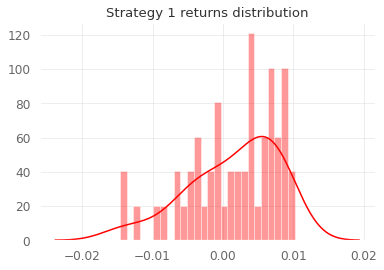

In [125]:
sns.distplot(pd.Series(returns_st1), hist=True, kde=True, color='red',  bins=SIZE//2).set_title('Strategy 1 returns distribution')

Text(0.5, 1.0, 'Strategy 2 returns distribution')

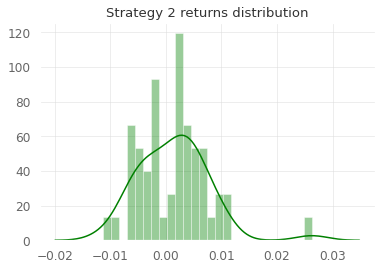

In [126]:
sns.distplot(pd.Series(returns_st2), hist=True, kde=True, color='green',  bins=SIZE//2).set_title('Strategy 2 returns distribution')

In [127]:
estimated_sr_std_st1 = estimated_sharpe_ratio_stdev(returns_st1)
estimated_sr_std_st2 = estimated_sharpe_ratio_stdev(returns_st2)

print('The estimated SR^ of strategy 1 have a stdDev of: ', estimated_sr_std_st1)
print('The estimated SR^ of strategy 2 have a stdDev of: ', estimated_sr_std_st2)

The estimated SR^ of strategy 1 have a stdDev of:  0.15340456477967432
The estimated SR^ of strategy 2 have a stdDev of:  0.12926526953817916


## Out-of-sample checks

**Now we will check if our decision of investing in strategy 2 instead of investing in the strategy 1 (that had a better SR), was a good or bad decision.**

For that we will generate extra, and bigger, samples of each distribution and chechk wich strategy have a better SR.
> Incresing the number of returns/samples for calcualting the SR^ makes the stdDev of this estimation drop drastically.

In [128]:
OOS_SIZE = 10000000

In [129]:
oos_returns_st1 = dist_st1.rvs(size=OOS_SIZE)

true_moments_st1 = moments(oos_returns_st1)
print(true_moments_st1)

mean    0.002028
std     0.006033
skew   -0.989043
kurt    3.857675
dtype: float64


In [130]:
true_sr_ann_st1 = ann_estimated_sharpe_ratio(oos_returns_st1, periods=52)
print('TRUE SR Annual. Strategy 1:', round(true_sr_ann_st1, 2))

TRUE SR Annual. Strategy 1: 2.42


In [131]:
oos_returns_st2 = dist_st2.rvs(size=OOS_SIZE)

true_moments_st2 = moments(oos_returns_st2)
print(true_moments_st2)

mean    0.003224
std     0.006033
skew    0.000689
kurt    2.998471
dtype: float64


In [132]:
true_sr_ann_st2 = ann_estimated_sharpe_ratio(oos_returns_st2, periods=52)
print('TRUE SR Annual. Strategy 2:', round(true_sr_ann_st2, 2))

TRUE SR Annual. Strategy 2: 3.85


## Conclusions
#### We can see that in the long term the Strategy 2 is much better than the Strategy 1. Its TRUE SR is around 3.85 and the TRUE SR of Strategy 1 is around 2.42. 
#### This is due to the `EXTRA_EDGE` we added tothe returns distributions of the Strategy 2. 
#### So, despite of the lower SR^ in the small sample, we were able to choose the best Strategy using the Probabilistic Sharpe Ratio (PSR). 
In 5 years our money will have grown x3 times more (aprox.) than if we had invested in the Strategy 1!

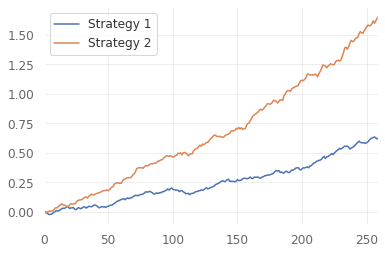

In [133]:
pd.DataFrame({'Strategy 1': pd.Series(oos_returns_st1).add(1).cumprod().sub(1).iloc[:52*5],
              'Strategy 2': pd.Series(oos_returns_st2).add(1).cumprod().sub(1).iloc[:52*5]}).plot()

With a density plot we can see how the Strategy 1 have a bigger tail in the negative side, that makes it have a higher risk.

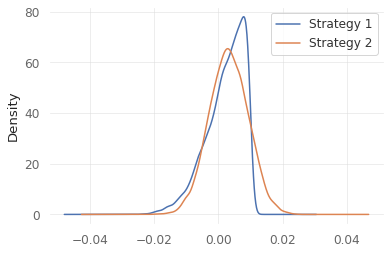

In [134]:
pd.DataFrame({'Strategy 1': pd.Series(oos_returns_st1).iloc[:10000],
              'Strategy 2': pd.Series(oos_returns_st2).iloc[:10000]}).plot.density()

NOTE: In this notebook we have checked the impact of the skewness in the SR^ but the kurtosis also have an impact on the SR^ and its estimated error. But there is no way for generating random returns with a predefined kurtosis.
> Let me know in a issue if you now one way to generate random returns with a desired kurtosis, or with a skewness greater than [-0.99, 0.99].